In [1]:
# Validation of the steady-state simulation - Case 1: MLP with Optimal settings
## Optimal Settings are like below:
# 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
# 2. Cd scaling -> replaced as normalization for both Cl and Cd
# 3. Seperate the ML models into the two models, a model only for Cl and the other for Cd
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 + 3 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 1000 # Mini-batch size
l2_regularizer=1e-07

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

beta = beta[3:]

In [5]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [6]:
t_interval = 0.001
t_len = int((15-10) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [8]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = [cm_target[-4],] + cm_target[:-4] + cm_target[-3:]

In [9]:
cm_target

['NACA0018cm_blade1.csv',
 'case1cm_blade1.csv',
 'case2cm_blade1.csv',
 'case4cm_blade1.csv',
 'case5cm_blade1.csv',
 'case7cm_blade1.csv',
 'case8cm_blade1.csv',
 'case13cm_blade1.csv',
 'case14cm_blade1.csv',
 'case15cm_blade1.csv',
 'case16cm_blade1.csv',
 'case17cm_blade1.csv',
 'case18cm_blade1.csv',
 'case19cm_blade1.csv',
 'case20cm_blade1.csv',
 'case21cm_blade1.csv']

In [10]:
# del cm_target[1,2,7,10,13]
del cm_target[10:13]
del cm_target[6]
del cm_target[5]
del cm_target[4]
del cm_target[3]
del cm_target[2]
del cm_target[1]
del cm_target[0]

In [11]:
cm_target

['case13cm_blade1.csv',
 'case14cm_blade1.csv',
 'case15cm_blade1.csv',
 'case19cm_blade1.csv',
 'case20cm_blade1.csv',
 'case21cm_blade1.csv']

In [12]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
    hh = generate_h(n_beta, t_len, normalize)
    bb = generate_beta(n_beta, t_len, normalize)
#     total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    #x = np.hstack((t, hh, bb, total_coords))
    #x = np.hstack((t, total_coords))
    #x = t
    x = np.hstack((t, hh, bb))
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x: ", x.shape)
    print("Dimension - y: ", y.shape)
    
    return x, y, t, cm

In [13]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    for i, file in enumerate(cm_target):
        df = pd.DataFrame()
        
        data = pd.read_csv(file, header=None)
        df = pd.concat([df, data], axis=0)
        
        time = df.iloc[:,0].values
        cm = df.iloc[:,1].values
        
        time_beUsed = time[np.where(np.logical_and(time>=10, time<15))]
        cm_beUsed = cm[np.where(np.logical_and(time>=10, time<15))]
        
        # Handle the time that is duplicated because of digits
        # Also, outliers are regulated at the second conditional statement.
        time_beUsed = handler_time(time_beUsed)
        cm_beUsed = handler_cm(cm_beUsed)
        
        linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
                                           bounds_error=False,kind='quadratic',
                                           fill_value='extrapolate')
        time_interp = np.arange(10, 15, t_interval).reshape((-1,1))
        cm_interp=linear_func(time_interp).reshape((-1,1))
        
        cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and Cm: ", input_time_cm.shape)
    return input_time_cm

In [14]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [15]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>0.3:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [16]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

#     beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = np.vstack((bb_imp, bb_imp, bb_imp))
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [17]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    #hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = np.concatenate((h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [18]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    
    baseline_coord_high = data.iloc[0,:]
    baseline_coord_low = data.iloc[1,:]
    baseline_coord = np.hstack((np.flip(baseline_coord_high), baseline_coord_low)).reshape((1,-1))
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    total_coords = np.hstack((airfoil_coord, flap_coords))
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [19]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,5))
    flap_right = np.zeros((15,5))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((5,1))

        for j in range(n_beta):
            betaValue = beta[j]

            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords2 = np.zeros((n_cases, 10))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    
    return flap_coords2

In [20]:
# Generating x, y and cm (for denormalizing)
x, y, t, cm = genereate_input_output(cm_target, n_beta, t_len, normalize=True)

Dimension - time and Cm:  (30000, 2)
Dimension - heights of Gurney flaps:  (30000, 1)
Dimension - inclination(beta):  (30000, 1)
Dimension - x:  (30000, 3)
Dimension - y:  (30000, 1)


In [21]:
x[:,0] -= 10
x[:,0] /= 5

In [22]:
x[:,0]

array([0.000e+00, 2.000e-04, 4.000e-04, ..., 9.994e-01, 9.996e-01,
       9.998e-01])

In [23]:
def dataset_split(x, y, cm, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_all, x_test, y_all, y_test, cm_all, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_train, x_val, y_train, y_val, cm_train, cm_val = train_test_split(x_all, y_all, cm_all, test_size=val_rate/(1-test_rate),
                                                                            random_state=kwargs.get('random_state'))
        return x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test
    else:
        x_train, x_test, y_train, y_test, cm_train, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_train, x_test, y_train, y_test, cm_train, cm_test

In [24]:
x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test = dataset_split(x, y, cm,
                                                                                          test_rate, val_rate=val_rate,
                                                                                          validation=True, random_state=50)

In [25]:
def make_mlp_model(num_layer:int = 1): # This function can only generate model with at least 3 hidden layers
    input_data = tf.keras.Input(shape=3)

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                #kernel_initializer='he_uniform',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(input_data)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     #kernel_initializer='he_uniform',
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       #kernel_initializer='he_uniform',
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model(input_data, output_data)
    
    return model

In [26]:
model = make_mlp_model(num_layer=n_layers)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 fc1 (Dense)                 (None, 256)               1024      
                                                                 
 fc2 (Dense)                 (None, 256)               65792     
                                                                 
 fc3 (Dense)                 (None, 256)               65792     
                                                                 
 fc4 (Dense)                 (None, 256)               65792     
                                                                 
 fc5 (Dense)                 (None, 256)               65792     
                                                                 
 outputLayer (Dense)         (None, 1)                 257   

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [28]:
model_directory = "D:\\TrainedModels\\20221229\\6beta"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [29]:
#ckpt_name = model_directory + "20221229unsteadyPrediction_MLP_10h_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_layers)+"layers_"+ str(n_units) +"units_checkpoint.h5"

#ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, min_delta=1e-05,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, factor=0.1,
                                          min_delta = 1e-5, min_lr=1e-05, verbose=1)

In [30]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
VALIDATION_STEPS = len(x_val)//batch_size

In [31]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    validation_data=[x_val, y_val],
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, rp])
end = datetime.datetime.now()

Epoch 1/10000
21/21 [==============================] - 5s 31ms/step - loss: 0.1075 - rmse: 0.3277 - val_loss: 0.0640 - val_rmse: 0.2528 - lr: 1.0000e-04
Epoch 2/10000
21/21 [==============================] - 0s 9ms/step - loss: 0.0620 - rmse: 0.2487 - val_loss: 0.0627 - val_rmse: 0.2501 - lr: 1.0000e-04
Epoch 3/10000
21/21 [==============================] - 0s 9ms/step - loss: 0.0597 - rmse: 0.2440 - val_loss: 0.0617 - val_rmse: 0.2482 - lr: 1.0000e-04
Epoch 4/10000
21/21 [==============================] - 0s 9ms/step - loss: 0.0589 - rmse: 0.2425 - val_loss: 0.0611 - val_rmse: 0.2469 - lr: 1.0000e-04
Epoch 5/10000
21/21 [==============================] - 0s 8ms/step - loss: 0.0587 - rmse: 0.2420 - val_loss: 0.0608 - val_rmse: 0.2464 - lr: 1.0000e-04
Epoch 6/10000
21/21 [==============================] - 0s 8ms/step - loss: 0.0586 - rmse: 0.2418 - val_loss: 0.0607 - val_rmse: 0.2462 - lr: 1.0000e-04
Epoch 7/10000
21/21 [==============================] - 0s 8ms/step - loss: 0.0585 - rms

21/21 [==============================] - 0s 7ms/step - loss: 0.0394 - rmse: 0.1982 - val_loss: 0.0404 - val_rmse: 0.2006 - lr: 1.0000e-04
Epoch 108/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0392 - rmse: 0.1977 - val_loss: 0.0398 - val_rmse: 0.1992 - lr: 1.0000e-04
Epoch 109/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0385 - rmse: 0.1959 - val_loss: 0.0396 - val_rmse: 0.1987 - lr: 1.0000e-04
Epoch 110/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0382 - rmse: 0.1953 - val_loss: 0.0392 - val_rmse: 0.1977 - lr: 1.0000e-04
Epoch 111/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0379 - rmse: 0.1945 - val_loss: 0.0393 - val_rmse: 0.1980 - lr: 1.0000e-04
Epoch 112/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0381 - rmse: 0.1950 - val_loss: 0.0387 - val_rmse: 0.1966 - lr: 1.0000e-04
Epoch 113/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0375 - rmse: 

21/21 [==============================] - 0s 7ms/step - loss: 0.0145 - rmse: 0.1200 - val_loss: 0.0148 - val_rmse: 0.1214 - lr: 1.0000e-04
Epoch 214/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0142 - rmse: 0.1188 - val_loss: 0.0146 - val_rmse: 0.1203 - lr: 1.0000e-04
Epoch 215/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0142 - rmse: 0.1190 - val_loss: 0.0144 - val_rmse: 0.1194 - lr: 1.0000e-04
Epoch 216/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0146 - rmse: 0.1206 - val_loss: 0.0166 - val_rmse: 0.1285 - lr: 1.0000e-04
Epoch 217/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0141 - rmse: 0.1183 - val_loss: 0.0143 - val_rmse: 0.1193 - lr: 1.0000e-04
Epoch 218/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0141 - rmse: 0.1183 - val_loss: 0.0142 - val_rmse: 0.1188 - lr: 1.0000e-04
Epoch 219/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0153 - rmse: 

21/21 [==============================] - 0s 7ms/step - loss: 0.0074 - rmse: 0.0856 - val_loss: 0.0077 - val_rmse: 0.0870 - lr: 1.0000e-04
Epoch 320/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0071 - rmse: 0.0836 - val_loss: 0.0074 - val_rmse: 0.0857 - lr: 1.0000e-04
Epoch 321/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0070 - rmse: 0.0834 - val_loss: 0.0074 - val_rmse: 0.0855 - lr: 1.0000e-04
Epoch 322/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0089 - rmse: 0.0939 - val_loss: 0.0079 - val_rmse: 0.0886 - lr: 1.0000e-04
Epoch 323/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0078 - rmse: 0.0881 - val_loss: 0.0074 - val_rmse: 0.0855 - lr: 1.0000e-04
Epoch 324/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0069 - rmse: 0.0826 - val_loss: 0.0084 - val_rmse: 0.0912 - lr: 1.0000e-04
Epoch 325/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0072 - rmse: 

21/21 [==============================] - 0s 7ms/step - loss: 0.0054 - rmse: 0.0731 - val_loss: 0.0050 - val_rmse: 0.0699 - lr: 1.0000e-04
Epoch 426/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0059 - rmse: 0.0761 - val_loss: 0.0084 - val_rmse: 0.0914 - lr: 1.0000e-04
Epoch 427/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0055 - rmse: 0.0736 - val_loss: 0.0073 - val_rmse: 0.0846 - lr: 1.0000e-04
Epoch 428/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0055 - rmse: 0.0735 - val_loss: 0.0053 - val_rmse: 0.0725 - lr: 1.0000e-04
Epoch 429/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0053 - rmse: 0.0723 - val_loss: 0.0058 - val_rmse: 0.0756 - lr: 1.0000e-04
Epoch 430/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0054 - rmse: 0.0725 - val_loss: 0.0070 - val_rmse: 0.0832 - lr: 1.0000e-04
Epoch 431/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0055 - rmse: 

21/21 [==============================] - 0s 7ms/step - loss: 0.0040 - rmse: 0.0625 - val_loss: 0.0037 - val_rmse: 0.0603 - lr: 1.0000e-04
Epoch 532/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0036 - rmse: 0.0596 - val_loss: 0.0037 - val_rmse: 0.0605 - lr: 1.0000e-04
Epoch 533/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0043 - rmse: 0.0649 - val_loss: 0.0096 - val_rmse: 0.0978 - lr: 1.0000e-04
Epoch 534/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0043 - rmse: 0.0649 - val_loss: 0.0034 - val_rmse: 0.0576 - lr: 1.0000e-04
Epoch 535/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0039 - rmse: 0.0615 - val_loss: 0.0040 - val_rmse: 0.0622 - lr: 1.0000e-04
Epoch 536/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0038 - rmse: 0.0612 - val_loss: 0.0046 - val_rmse: 0.0669 - lr: 1.0000e-04
Epoch 537/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0035 - rmse: 

21/21 [==============================] - 0s 7ms/step - loss: 0.0026 - rmse: 0.0499 - val_loss: 0.0028 - val_rmse: 0.0522 - lr: 1.0000e-04
Epoch 638/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0039 - rmse: 0.0616 - val_loss: 0.0127 - val_rmse: 0.1124 - lr: 1.0000e-04
Epoch 639/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0046 - rmse: 0.0673 - val_loss: 0.0037 - val_rmse: 0.0601 - lr: 1.0000e-04
Epoch 640/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0043 - rmse: 0.0650 - val_loss: 0.0054 - val_rmse: 0.0728 - lr: 1.0000e-04
Epoch 641/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0035 - rmse: 0.0587 - val_loss: 0.0028 - val_rmse: 0.0522 - lr: 1.0000e-04
Epoch 642/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0030 - rmse: 0.0536 - val_loss: 0.0028 - val_rmse: 0.0520 - lr: 1.0000e-04
Epoch 643/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0034 - rmse: 

21/21 [==============================] - 0s 7ms/step - loss: 0.0025 - rmse: 0.0489 - val_loss: 0.0023 - val_rmse: 0.0467 - lr: 1.0000e-04
Epoch 744/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0029 - rmse: 0.0534 - val_loss: 0.0042 - val_rmse: 0.0641 - lr: 1.0000e-04
Epoch 745/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0024 - rmse: 0.0478 - val_loss: 0.0021 - val_rmse: 0.0449 - lr: 1.0000e-04
Epoch 746/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0019 - rmse: 0.0429 - val_loss: 0.0020 - val_rmse: 0.0440 - lr: 1.0000e-04
Epoch 747/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0023 - rmse: 0.0470 - val_loss: 0.0037 - val_rmse: 0.0600 - lr: 1.0000e-04
Epoch 748/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0034 - rmse: 0.0572 - val_loss: 0.0023 - val_rmse: 0.0468 - lr: 1.0000e-04
Epoch 749/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0024 - rmse: 

21/21 [==============================] - 0s 7ms/step - loss: 0.0017 - rmse: 0.0403 - val_loss: 0.0017 - val_rmse: 0.0406 - lr: 1.0000e-04
Epoch 850/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0021 - rmse: 0.0449 - val_loss: 0.0017 - val_rmse: 0.0401 - lr: 1.0000e-04
Epoch 851/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0024 - rmse: 0.0481 - val_loss: 0.0020 - val_rmse: 0.0435 - lr: 1.0000e-04
Epoch 852/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0022 - rmse: 0.0461 - val_loss: 0.0063 - val_rmse: 0.0790 - lr: 1.0000e-04
Epoch 853/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0032 - rmse: 0.0555 - val_loss: 0.0031 - val_rmse: 0.0549 - lr: 1.0000e-04
Epoch 854/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0024 - rmse: 0.0479 - val_loss: 0.0024 - val_rmse: 0.0482 - lr: 1.0000e-04
Epoch 855/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0017 - rmse: 

21/21 [==============================] - 0s 8ms/step - loss: 0.0035 - rmse: 0.0588 - val_loss: 0.0048 - val_rmse: 0.0684 - lr: 1.0000e-04
Epoch 956/10000
21/21 [==============================] - 0s 8ms/step - loss: 0.0025 - rmse: 0.0489 - val_loss: 0.0015 - val_rmse: 0.0373 - lr: 1.0000e-04
Epoch 957/10000
21/21 [==============================] - 0s 8ms/step - loss: 0.0014 - rmse: 0.0366 - val_loss: 0.0015 - val_rmse: 0.0378 - lr: 1.0000e-04
Epoch 958/10000
21/21 [==============================] - 0s 9ms/step - loss: 0.0014 - rmse: 0.0358 - val_loss: 0.0013 - val_rmse: 0.0353 - lr: 1.0000e-04
Epoch 959/10000
21/21 [==============================] - 0s 8ms/step - loss: 0.0014 - rmse: 0.0357 - val_loss: 0.0015 - val_rmse: 0.0378 - lr: 1.0000e-04
Epoch 960/10000
21/21 [==============================] - 0s 8ms/step - loss: 0.0014 - rmse: 0.0360 - val_loss: 0.0016 - val_rmse: 0.0383 - lr: 1.0000e-04
Epoch 961/10000
21/21 [==============================] - 0s 8ms/step - loss: 0.0029 - rmse: 

Epoch 1061/10000
21/21 [==============================] - 0s 8ms/step - loss: 0.0025 - rmse: 0.0486 - val_loss: 0.0019 - val_rmse: 0.0423 - lr: 1.0000e-04
Epoch 1062/10000
21/21 [==============================] - 0s 8ms/step - loss: 0.0017 - rmse: 0.0407 - val_loss: 0.0012 - val_rmse: 0.0336 - lr: 1.0000e-04
Epoch 1063/10000
21/21 [==============================] - 0s 8ms/step - loss: 0.0021 - rmse: 0.0447 - val_loss: 0.0024 - val_rmse: 0.0486 - lr: 1.0000e-04
Epoch 1064/10000
21/21 [==============================] - 0s 8ms/step - loss: 0.0013 - rmse: 0.0353 - val_loss: 0.0015 - val_rmse: 0.0376 - lr: 1.0000e-04
Epoch 1065/10000
21/21 [==============================] - 0s 8ms/step - loss: 0.0022 - rmse: 0.0464 - val_loss: 0.0025 - val_rmse: 0.0493 - lr: 1.0000e-04
Epoch 1066/10000
21/21 [==============================] - 0s 8ms/step - loss: 0.0018 - rmse: 0.0408 - val_loss: 0.0031 - val_rmse: 0.0544 - lr: 1.0000e-04
Epoch 1067/10000
21/21 [==============================] - 0s 8ms/step 

Epoch 1114/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0014 - rmse: 0.0368 - val_loss: 0.0015 - val_rmse: 0.0372 - lr: 1.0000e-04
Epoch 1115/10000
21/21 [==============================] - 0s 8ms/step - loss: 0.0019 - rmse: 0.0426 - val_loss: 0.0027 - val_rmse: 0.0510 - lr: 1.0000e-04
Epoch 1116/10000
21/21 [==============================] - 0s 8ms/step - loss: 0.0019 - rmse: 0.0420 - val_loss: 0.0014 - val_rmse: 0.0358 - lr: 1.0000e-04
Epoch 1117/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0011 - rmse: 0.0318 - val_loss: 0.0012 - val_rmse: 0.0331 - lr: 1.0000e-04
Epoch 1118/10000
21/21 [==============================] - 0s 8ms/step - loss: 0.0015 - rmse: 0.0381 - val_loss: 0.0023 - val_rmse: 0.0475 - lr: 1.0000e-04
Epoch 1119/10000
21/21 [==============================] - 0s 8ms/step - loss: 0.0014 - rmse: 0.0367 - val_loss: 0.0015 - val_rmse: 0.0375 - lr: 1.0000e-04
Epoch 1120/10000
21/21 [==============================] - 0s 8ms/step 

Epoch 1167/10000
21/21 [==============================] - 0s 8ms/step - loss: 0.0035 - rmse: 0.0586 - val_loss: 0.0031 - val_rmse: 0.0550 - lr: 1.0000e-04
Epoch 1168/10000
21/21 [==============================] - 0s 8ms/step - loss: 0.0014 - rmse: 0.0368 - val_loss: 0.0013 - val_rmse: 0.0350 - lr: 1.0000e-04
Epoch 1169/10000
21/21 [==============================] - 0s 8ms/step - loss: 0.0011 - rmse: 0.0310 - val_loss: 0.0010 - val_rmse: 0.0304 - lr: 1.0000e-04
Epoch 1170/10000
21/21 [==============================] - 0s 8ms/step - loss: 0.0010 - rmse: 0.0308 - val_loss: 0.0032 - val_rmse: 0.0561 - lr: 1.0000e-04
Epoch 1171/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0028 - rmse: 0.0519 - val_loss: 0.0011 - val_rmse: 0.0310 - lr: 1.0000e-04
Epoch 1172/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0013 - rmse: 0.0349 - val_loss: 0.0012 - val_rmse: 0.0338 - lr: 1.0000e-04
Epoch 1173/10000
21/21 [==============================] - 0s 7ms/step 

Epoch 1220/10000
21/21 [==============================] - 0s 8ms/step - loss: 0.0018 - rmse: 0.0417 - val_loss: 0.0011 - val_rmse: 0.0318 - lr: 1.0000e-04
Epoch 1221/10000
21/21 [==============================] - 0s 8ms/step - loss: 0.0020 - rmse: 0.0437 - val_loss: 0.0017 - val_rmse: 0.0397 - lr: 1.0000e-04
Epoch 1222/10000
21/21 [==============================] - 0s 8ms/step - loss: 0.0014 - rmse: 0.0364 - val_loss: 0.0013 - val_rmse: 0.0342 - lr: 1.0000e-04
Epoch 1223/10000
21/21 [==============================] - 0s 8ms/step - loss: 0.0011 - rmse: 0.0323 - val_loss: 0.0011 - val_rmse: 0.0316 - lr: 1.0000e-04
Epoch 1224/10000
21/21 [==============================] - 0s 8ms/step - loss: 0.0012 - rmse: 0.0333 - val_loss: 0.0031 - val_rmse: 0.0544 - lr: 1.0000e-04
Epoch 1225/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0013 - rmse: 0.0345 - val_loss: 0.0017 - val_rmse: 0.0402 - lr: 1.0000e-04
Epoch 1226/10000
21/21 [==============================] - 0s 7ms/step 

21/21 [==============================] - 0s 7ms/step - loss: 0.0020 - rmse: 0.0439 - val_loss: 0.0068 - val_rmse: 0.0817 - lr: 1.0000e-04
Epoch 1325/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0029 - rmse: 0.0532 - val_loss: 9.6772e-04 - val_rmse: 0.0296 - lr: 1.0000e-04
Epoch 1326/10000
21/21 [==============================] - 0s 8ms/step - loss: 0.0010 - rmse: 0.0309 - val_loss: 9.1198e-04 - val_rmse: 0.0287 - lr: 1.0000e-04
Epoch 1327/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0016 - rmse: 0.0383 - val_loss: 0.0016 - val_rmse: 0.0391 - lr: 1.0000e-04
Epoch 1328/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0013 - rmse: 0.0346 - val_loss: 0.0022 - val_rmse: 0.0459 - lr: 1.0000e-04
Epoch 1329/10000
21/21 [==============================] - 0s 8ms/step - loss: 0.0019 - rmse: 0.0425 - val_loss: 0.0018 - val_rmse: 0.0411 - lr: 1.0000e-04
Epoch 1330/10000
21/21 [==============================] - 0s 7ms/step - loss: 9

21/21 [==============================] - 0s 7ms/step - loss: 0.0017 - rmse: 0.0399 - val_loss: 8.6571e-04 - val_rmse: 0.0279 - lr: 1.0000e-04
Epoch 1377/10000
21/21 [==============================] - 0s 8ms/step - loss: 8.0556e-04 - rmse: 0.0268 - val_loss: 0.0011 - val_rmse: 0.0318 - lr: 1.0000e-04
Epoch 1378/10000
21/21 [==============================] - 0s 7ms/step - loss: 9.4217e-04 - rmse: 0.0292 - val_loss: 0.0034 - val_rmse: 0.0571 - lr: 1.0000e-04
Epoch 1379/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0016 - rmse: 0.0383 - val_loss: 0.0042 - val_rmse: 0.0637 - lr: 1.0000e-04
Epoch 1380/10000
21/21 [==============================] - 0s 8ms/step - loss: 0.0018 - rmse: 0.0411 - val_loss: 0.0028 - val_rmse: 0.0524 - lr: 1.0000e-04
Epoch 1381/10000
21/21 [==============================] - 0s 8ms/step - loss: 0.0027 - rmse: 0.0511 - val_loss: 0.0030 - val_rmse: 0.0541 - lr: 1.0000e-04
Epoch 1382/10000
21/21 [==============================] - 0s 8ms/step - los

Epoch 1480/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0014 - rmse: 0.0358 - val_loss: 0.0013 - val_rmse: 0.0354 - lr: 1.0000e-04
Epoch 1481/10000
21/21 [==============================] - 0s 7ms/step - loss: 7.9772e-04 - rmse: 0.0266 - val_loss: 8.1208e-04 - val_rmse: 0.0269 - lr: 1.0000e-04
Epoch 1482/10000
21/21 [==============================] - 0s 8ms/step - loss: 8.2274e-04 - rmse: 0.0271 - val_loss: 7.8472e-04 - val_rmse: 0.0264 - lr: 1.0000e-04
Epoch 1483/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0022 - rmse: 0.0459 - val_loss: 9.2716e-04 - val_rmse: 0.0289 - lr: 1.0000e-04
Epoch 1484/10000
21/21 [==============================] - 0s 8ms/step - loss: 8.3335e-04 - rmse: 0.0273 - val_loss: 7.9051e-04 - val_rmse: 0.0265 - lr: 1.0000e-04
Epoch 1485/10000
21/21 [==============================] - 0s 8ms/step - loss: 0.0012 - rmse: 0.0328 - val_loss: 0.0013 - val_rmse: 0.0342 - lr: 1.0000e-04
Epoch 1486/10000
21/21 [==================

Epoch 1532/10000
21/21 [==============================] - 0s 8ms/step - loss: 9.1221e-04 - rmse: 0.0287 - val_loss: 0.0018 - val_rmse: 0.0410 - lr: 1.0000e-04
Epoch 1533/10000
21/21 [==============================] - 0s 8ms/step - loss: 0.0017 - rmse: 0.0401 - val_loss: 0.0018 - val_rmse: 0.0417 - lr: 1.0000e-04
Epoch 1534/10000
21/21 [==============================] - 0s 8ms/step - loss: 8.5882e-04 - rmse: 0.0277 - val_loss: 7.1967e-04 - val_rmse: 0.0251 - lr: 1.0000e-04
Epoch 1535/10000
21/21 [==============================] - 0s 8ms/step - loss: 9.6085e-04 - rmse: 0.0295 - val_loss: 8.7812e-04 - val_rmse: 0.0281 - lr: 1.0000e-04
Epoch 1536/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0023 - rmse: 0.0469 - val_loss: 8.0795e-04 - val_rmse: 0.0268 - lr: 1.0000e-04
Epoch 1537/10000
21/21 [==============================] - 0s 7ms/step - loss: 8.6606e-04 - rmse: 0.0278 - val_loss: 7.8388e-04 - val_rmse: 0.0263 - lr: 1.0000e-04
Epoch 1538/10000
21/21 [==============

Epoch 1584/10000
21/21 [==============================] - 0s 8ms/step - loss: 0.0010 - rmse: 0.0308 - val_loss: 0.0011 - val_rmse: 0.0323 - lr: 1.0000e-04
Epoch 1585/10000
21/21 [==============================] - 0s 8ms/step - loss: 0.0011 - rmse: 0.0310 - val_loss: 0.0030 - val_rmse: 0.0541 - lr: 1.0000e-04
Epoch 1586/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0029 - rmse: 0.0526 - val_loss: 0.0015 - val_rmse: 0.0375 - lr: 1.0000e-04
Epoch 1587/10000
21/21 [==============================] - 0s 8ms/step - loss: 9.0809e-04 - rmse: 0.0286 - val_loss: 7.5261e-04 - val_rmse: 0.0257 - lr: 1.0000e-04
Epoch 1588/10000
21/21 [==============================] - 0s 8ms/step - loss: 0.0012 - rmse: 0.0333 - val_loss: 9.5341e-04 - val_rmse: 0.0294 - lr: 1.0000e-04
Epoch 1589/10000
21/21 [==============================] - 0s 8ms/step - loss: 0.0012 - rmse: 0.0330 - val_loss: 7.8123e-04 - val_rmse: 0.0263 - lr: 1.0000e-04
Epoch 1590/10000
21/21 [==============================

Epoch 1636/10000
21/21 [==============================] - 0s 8ms/step - loss: 8.2967e-04 - rmse: 0.0272 - val_loss: 7.6431e-04 - val_rmse: 0.0259 - lr: 1.0000e-04
Epoch 1637/10000
21/21 [==============================] - 0s 8ms/step - loss: 9.0271e-04 - rmse: 0.0285 - val_loss: 6.7382e-04 - val_rmse: 0.0241 - lr: 1.0000e-04
Epoch 1638/10000
21/21 [==============================] - 0s 8ms/step - loss: 8.5595e-04 - rmse: 0.0277 - val_loss: 9.5073e-04 - val_rmse: 0.0293 - lr: 1.0000e-04
Epoch 1639/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.0019 - rmse: 0.0420 - val_loss: 7.7530e-04 - val_rmse: 0.0262 - lr: 1.0000e-04
Epoch 1640/10000
21/21 [==============================] - 0s 8ms/step - loss: 8.5480e-04 - rmse: 0.0276 - val_loss: 0.0011 - val_rmse: 0.0312 - lr: 1.0000e-04
Epoch 1641/10000
21/21 [==============================] - 0s 8ms/step - loss: 0.0015 - rmse: 0.0376 - val_loss: 0.0011 - val_rmse: 0.0320 - lr: 1.0000e-04
Epoch 1642/10000
21/21 [==============

21/21 [==============================] - 0s 7ms/step - loss: 5.0188e-04 - rmse: 0.0203 - val_loss: 5.7543e-04 - val_rmse: 0.0220 - lr: 1.0000e-05
Epoch 1737/10000
21/21 [==============================] - 0s 7ms/step - loss: 5.0333e-04 - rmse: 0.0203 - val_loss: 5.7039e-04 - val_rmse: 0.0219 - lr: 1.0000e-05
Epoch 1738/10000
21/21 [==============================] - 0s 7ms/step - loss: 5.0319e-04 - rmse: 0.0203 - val_loss: 5.6907e-04 - val_rmse: 0.0219 - lr: 1.0000e-05
Epoch 1739/10000
21/21 [==============================] - 0s 7ms/step - loss: 5.0346e-04 - rmse: 0.0203 - val_loss: 5.6800e-04 - val_rmse: 0.0218 - lr: 1.0000e-05
Epoch 1740/10000
21/21 [==============================] - 0s 7ms/step - loss: 5.0177e-04 - rmse: 0.0203 - val_loss: 5.6895e-04 - val_rmse: 0.0219 - lr: 1.0000e-05
Epoch 1741/10000
21/21 [==============================] - 0s 7ms/step - loss: 5.0189e-04 - rmse: 0.0203 - val_loss: 5.6968e-04 - val_rmse: 0.0219 - lr: 1.0000e-05
Epoch 1742/10000
21/21 [===============

21/21 [==============================] - 0s 8ms/step - loss: 4.8856e-04 - rmse: 0.0199 - val_loss: 5.4344e-04 - val_rmse: 0.0213 - lr: 1.0000e-05
Epoch 1837/10000
21/21 [==============================] - 0s 8ms/step - loss: 4.9671e-04 - rmse: 0.0201 - val_loss: 5.5001e-04 - val_rmse: 0.0214 - lr: 1.0000e-05
Epoch 1838/10000
21/21 [==============================] - 0s 8ms/step - loss: 4.9904e-04 - rmse: 0.0202 - val_loss: 5.7570e-04 - val_rmse: 0.0220 - lr: 1.0000e-05
Epoch 1839/10000
21/21 [==============================] - 0s 8ms/step - loss: 4.9545e-04 - rmse: 0.0201 - val_loss: 5.4222e-04 - val_rmse: 0.0212 - lr: 1.0000e-05
Epoch 1840/10000
21/21 [==============================] - 0s 8ms/step - loss: 4.9350e-04 - rmse: 0.0201 - val_loss: 5.4573e-04 - val_rmse: 0.0213 - lr: 1.0000e-05
Epoch 1841/10000
21/21 [==============================] - 0s 7ms/step - loss: 5.1217e-04 - rmse: 0.0205 - val_loss: 5.5121e-04 - val_rmse: 0.0214 - lr: 1.0000e-05
Epoch 1842/10000
21/21 [===============

21/21 [==============================] - 0s 8ms/step - loss: 4.6383e-04 - rmse: 0.0193 - val_loss: 5.5704e-04 - val_rmse: 0.0216 - lr: 1.0000e-05
Epoch 1937/10000
21/21 [==============================] - 0s 8ms/step - loss: 4.7047e-04 - rmse: 0.0195 - val_loss: 5.1143e-04 - val_rmse: 0.0205 - lr: 1.0000e-05
Epoch 1938/10000
21/21 [==============================] - 0s 8ms/step - loss: 4.6320e-04 - rmse: 0.0193 - val_loss: 5.1453e-04 - val_rmse: 0.0206 - lr: 1.0000e-05
Epoch 1939/10000
21/21 [==============================] - 0s 8ms/step - loss: 4.7846e-04 - rmse: 0.0197 - val_loss: 5.1402e-04 - val_rmse: 0.0206 - lr: 1.0000e-05
Epoch 1940/10000
21/21 [==============================] - 0s 7ms/step - loss: 5.0559e-04 - rmse: 0.0204 - val_loss: 5.8185e-04 - val_rmse: 0.0221 - lr: 1.0000e-05
Epoch 1941/10000
21/21 [==============================] - 0s 7ms/step - loss: 5.1050e-04 - rmse: 0.0205 - val_loss: 6.2046e-04 - val_rmse: 0.0230 - lr: 1.0000e-05
Epoch 1942/10000
21/21 [===============

21/21 [==============================] - 0s 7ms/step - loss: 4.4713e-04 - rmse: 0.0189 - val_loss: 4.8757e-04 - val_rmse: 0.0199 - lr: 1.0000e-05
Epoch 2037/10000
21/21 [==============================] - 0s 8ms/step - loss: 4.4075e-04 - rmse: 0.0187 - val_loss: 4.9140e-04 - val_rmse: 0.0200 - lr: 1.0000e-05
Epoch 2038/10000
21/21 [==============================] - 0s 7ms/step - loss: 4.4455e-04 - rmse: 0.0188 - val_loss: 5.0761e-04 - val_rmse: 0.0204 - lr: 1.0000e-05
Epoch 2039/10000
21/21 [==============================] - 0s 8ms/step - loss: 4.3874e-04 - rmse: 0.0186 - val_loss: 4.8083e-04 - val_rmse: 0.0197 - lr: 1.0000e-05
Epoch 2040/10000
21/21 [==============================] - 0s 7ms/step - loss: 4.4394e-04 - rmse: 0.0188 - val_loss: 4.8500e-04 - val_rmse: 0.0198 - lr: 1.0000e-05
Epoch 2041/10000
21/21 [==============================] - 0s 8ms/step - loss: 4.3941e-04 - rmse: 0.0187 - val_loss: 4.9782e-04 - val_rmse: 0.0202 - lr: 1.0000e-05
Epoch 2042/10000
21/21 [===============

21/21 [==============================] - 0s 8ms/step - loss: 4.1988e-04 - rmse: 0.0181 - val_loss: 4.6454e-04 - val_rmse: 0.0193 - lr: 1.0000e-05
Epoch 2137/10000
21/21 [==============================] - 0s 8ms/step - loss: 4.2644e-04 - rmse: 0.0183 - val_loss: 4.6329e-04 - val_rmse: 0.0193 - lr: 1.0000e-05
Epoch 2138/10000
21/21 [==============================] - 0s 7ms/step - loss: 4.1676e-04 - rmse: 0.0180 - val_loss: 4.7770e-04 - val_rmse: 0.0197 - lr: 1.0000e-05
Epoch 2139/10000
21/21 [==============================] - 0s 8ms/step - loss: 4.2040e-04 - rmse: 0.0181 - val_loss: 4.8341e-04 - val_rmse: 0.0198 - lr: 1.0000e-05
Epoch 2140/10000
21/21 [==============================] - 0s 8ms/step - loss: 4.2339e-04 - rmse: 0.0182 - val_loss: 4.6599e-04 - val_rmse: 0.0194 - lr: 1.0000e-05
Epoch 2141/10000
21/21 [==============================] - 0s 7ms/step - loss: 4.1660e-04 - rmse: 0.0180 - val_loss: 4.6449e-04 - val_rmse: 0.0193 - lr: 1.0000e-05
Epoch 2142/10000
21/21 [===============

21/21 [==============================] - 0s 8ms/step - loss: 4.0571e-04 - rmse: 0.0177 - val_loss: 4.4709e-04 - val_rmse: 0.0189 - lr: 1.0000e-05
Epoch 2237/10000
21/21 [==============================] - 0s 8ms/step - loss: 4.0974e-04 - rmse: 0.0178 - val_loss: 4.8827e-04 - val_rmse: 0.0199 - lr: 1.0000e-05
Epoch 2238/10000
21/21 [==============================] - 0s 8ms/step - loss: 4.1253e-04 - rmse: 0.0179 - val_loss: 4.5405e-04 - val_rmse: 0.0190 - lr: 1.0000e-05
Epoch 2239/10000
21/21 [==============================] - 0s 8ms/step - loss: 4.2582e-04 - rmse: 0.0183 - val_loss: 4.7976e-04 - val_rmse: 0.0197 - lr: 1.0000e-05
Epoch 2240/10000
21/21 [==============================] - 0s 8ms/step - loss: 4.1719e-04 - rmse: 0.0180 - val_loss: 4.6266e-04 - val_rmse: 0.0193 - lr: 1.0000e-05
Epoch 2241/10000
21/21 [==============================] - 0s 8ms/step - loss: 4.0771e-04 - rmse: 0.0178 - val_loss: 4.4129e-04 - val_rmse: 0.0187 - lr: 1.0000e-05
Epoch 2242/10000
21/21 [===============

21/21 [==============================] - 0s 7ms/step - loss: 3.9903e-04 - rmse: 0.0175 - val_loss: 4.6696e-04 - val_rmse: 0.0194 - lr: 1.0000e-05
Epoch 2337/10000
21/21 [==============================] - 0s 7ms/step - loss: 3.8636e-04 - rmse: 0.0172 - val_loss: 4.2326e-04 - val_rmse: 0.0182 - lr: 1.0000e-05
Epoch 2338/10000
21/21 [==============================] - 0s 7ms/step - loss: 3.9813e-04 - rmse: 0.0175 - val_loss: 4.4333e-04 - val_rmse: 0.0188 - lr: 1.0000e-05
Epoch 2339/10000
21/21 [==============================] - 0s 8ms/step - loss: 3.9996e-04 - rmse: 0.0176 - val_loss: 4.2984e-04 - val_rmse: 0.0184 - lr: 1.0000e-05
Epoch 2340/10000
21/21 [==============================] - 0s 7ms/step - loss: 3.9533e-04 - rmse: 0.0174 - val_loss: 4.2532e-04 - val_rmse: 0.0183 - lr: 1.0000e-05
Epoch 2341/10000
21/21 [==============================] - 0s 8ms/step - loss: 3.7944e-04 - rmse: 0.0170 - val_loss: 4.2901e-04 - val_rmse: 0.0184 - lr: 1.0000e-05
Epoch 2342/10000
21/21 [===============

21/21 [==============================] - 0s 8ms/step - loss: 3.7028e-04 - rmse: 0.0167 - val_loss: 4.1574e-04 - val_rmse: 0.0180 - lr: 1.0000e-05
Epoch 2437/10000
21/21 [==============================] - 0s 8ms/step - loss: 3.7050e-04 - rmse: 0.0167 - val_loss: 4.2693e-04 - val_rmse: 0.0183 - lr: 1.0000e-05
Epoch 2438/10000
21/21 [==============================] - 0s 8ms/step - loss: 3.8490e-04 - rmse: 0.0171 - val_loss: 4.1077e-04 - val_rmse: 0.0179 - lr: 1.0000e-05
Epoch 2439/10000
21/21 [==============================] - 0s 8ms/step - loss: 3.7627e-04 - rmse: 0.0169 - val_loss: 4.3163e-04 - val_rmse: 0.0184 - lr: 1.0000e-05
Epoch 2440/10000
21/21 [==============================] - 0s 8ms/step - loss: 3.7917e-04 - rmse: 0.0170 - val_loss: 4.2485e-04 - val_rmse: 0.0183 - lr: 1.0000e-05
Epoch 2441/10000
21/21 [==============================] - 0s 7ms/step - loss: 3.7716e-04 - rmse: 0.0169 - val_loss: 4.2043e-04 - val_rmse: 0.0181 - lr: 1.0000e-05
Epoch 2442/10000
21/21 [===============

21/21 [==============================] - 0s 8ms/step - loss: 3.8243e-04 - rmse: 0.0171 - val_loss: 4.0717e-04 - val_rmse: 0.0178 - lr: 1.0000e-05
Epoch 2537/10000
21/21 [==============================] - 0s 8ms/step - loss: 3.8978e-04 - rmse: 0.0173 - val_loss: 4.9510e-04 - val_rmse: 0.0201 - lr: 1.0000e-05
Epoch 2538/10000
21/21 [==============================] - 0s 7ms/step - loss: 3.7908e-04 - rmse: 0.0170 - val_loss: 3.9825e-04 - val_rmse: 0.0175 - lr: 1.0000e-05
Epoch 2539/10000
21/21 [==============================] - 0s 8ms/step - loss: 3.7355e-04 - rmse: 0.0168 - val_loss: 3.9510e-04 - val_rmse: 0.0174 - lr: 1.0000e-05
Epoch 2540/10000
21/21 [==============================] - 0s 8ms/step - loss: 3.5859e-04 - rmse: 0.0163 - val_loss: 3.9632e-04 - val_rmse: 0.0175 - lr: 1.0000e-05
Epoch 2541/10000
21/21 [==============================] - 0s 8ms/step - loss: 3.6979e-04 - rmse: 0.0167 - val_loss: 4.0503e-04 - val_rmse: 0.0177 - lr: 1.0000e-05
Epoch 2542/10000
21/21 [===============

21/21 [==============================] - 0s 8ms/step - loss: 3.5846e-04 - rmse: 0.0163 - val_loss: 3.8428e-04 - val_rmse: 0.0171 - lr: 1.0000e-05
Epoch 2637/10000
21/21 [==============================] - 0s 7ms/step - loss: 3.5877e-04 - rmse: 0.0164 - val_loss: 3.8152e-04 - val_rmse: 0.0170 - lr: 1.0000e-05
Epoch 2638/10000
21/21 [==============================] - 0s 8ms/step - loss: 3.4570e-04 - rmse: 0.0159 - val_loss: 3.7602e-04 - val_rmse: 0.0169 - lr: 1.0000e-05
Epoch 2639/10000
21/21 [==============================] - 0s 8ms/step - loss: 3.6884e-04 - rmse: 0.0167 - val_loss: 4.1120e-04 - val_rmse: 0.0179 - lr: 1.0000e-05
Epoch 2640/10000
21/21 [==============================] - 0s 8ms/step - loss: 3.5718e-04 - rmse: 0.0163 - val_loss: 4.0376e-04 - val_rmse: 0.0177 - lr: 1.0000e-05
Epoch 2641/10000
21/21 [==============================] - 0s 8ms/step - loss: 3.4596e-04 - rmse: 0.0160 - val_loss: 3.7957e-04 - val_rmse: 0.0170 - lr: 1.0000e-05
Epoch 2642/10000
21/21 [===============

21/21 [==============================] - 0s 7ms/step - loss: 3.3948e-04 - rmse: 0.0158 - val_loss: 3.9027e-04 - val_rmse: 0.0173 - lr: 1.0000e-05
Epoch 2737/10000
21/21 [==============================] - 0s 8ms/step - loss: 3.4274e-04 - rmse: 0.0159 - val_loss: 3.8832e-04 - val_rmse: 0.0172 - lr: 1.0000e-05
Epoch 2738/10000
21/21 [==============================] - 0s 7ms/step - loss: 3.3251e-04 - rmse: 0.0155 - val_loss: 3.5694e-04 - val_rmse: 0.0163 - lr: 1.0000e-05
Epoch 2739/10000
21/21 [==============================] - 0s 8ms/step - loss: 3.3486e-04 - rmse: 0.0156 - val_loss: 3.6378e-04 - val_rmse: 0.0165 - lr: 1.0000e-05
Epoch 2740/10000
21/21 [==============================] - 0s 7ms/step - loss: 3.3129e-04 - rmse: 0.0155 - val_loss: 3.7517e-04 - val_rmse: 0.0168 - lr: 1.0000e-05
Epoch 2741/10000
21/21 [==============================] - 0s 8ms/step - loss: 3.3835e-04 - rmse: 0.0157 - val_loss: 3.8561e-04 - val_rmse: 0.0172 - lr: 1.0000e-05
Epoch 2742/10000
21/21 [===============

21/21 [==============================] - 0s 8ms/step - loss: 3.2772e-04 - rmse: 0.0154 - val_loss: 3.4815e-04 - val_rmse: 0.0160 - lr: 1.0000e-05
Epoch 2837/10000
21/21 [==============================] - 0s 8ms/step - loss: 3.2066e-04 - rmse: 0.0151 - val_loss: 3.6419e-04 - val_rmse: 0.0165 - lr: 1.0000e-05
Epoch 2838/10000
21/21 [==============================] - 0s 7ms/step - loss: 3.2931e-04 - rmse: 0.0154 - val_loss: 4.2090e-04 - val_rmse: 0.0182 - lr: 1.0000e-05
Epoch 2839/10000
21/21 [==============================] - 0s 7ms/step - loss: 3.5297e-04 - rmse: 0.0162 - val_loss: 4.0046e-04 - val_rmse: 0.0176 - lr: 1.0000e-05
Epoch 2840/10000
21/21 [==============================] - 0s 8ms/step - loss: 3.5513e-04 - rmse: 0.0162 - val_loss: 3.5618e-04 - val_rmse: 0.0163 - lr: 1.0000e-05
Epoch 2841/10000
21/21 [==============================] - 0s 7ms/step - loss: 3.5568e-04 - rmse: 0.0163 - val_loss: 4.5889e-04 - val_rmse: 0.0192 - lr: 1.0000e-05
Epoch 2842/10000
21/21 [===============

21/21 [==============================] - 0s 8ms/step - loss: 3.4258e-04 - rmse: 0.0159 - val_loss: 3.7017e-04 - val_rmse: 0.0167 - lr: 1.0000e-05
Epoch 2937/10000
21/21 [==============================] - 0s 8ms/step - loss: 3.4259e-04 - rmse: 0.0159 - val_loss: 3.4825e-04 - val_rmse: 0.0160 - lr: 1.0000e-05
Epoch 2938/10000
21/21 [==============================] - 0s 8ms/step - loss: 3.3000e-04 - rmse: 0.0155 - val_loss: 3.5664e-04 - val_rmse: 0.0163 - lr: 1.0000e-05
Epoch 2939/10000
21/21 [==============================] - 0s 8ms/step - loss: 3.2216e-04 - rmse: 0.0152 - val_loss: 3.6335e-04 - val_rmse: 0.0165 - lr: 1.0000e-05
Epoch 2940/10000
21/21 [==============================] - 0s 8ms/step - loss: 3.1351e-04 - rmse: 0.0149 - val_loss: 3.5298e-04 - val_rmse: 0.0162 - lr: 1.0000e-05
Epoch 2941/10000
21/21 [==============================] - 0s 7ms/step - loss: 3.2938e-04 - rmse: 0.0154 - val_loss: 4.5157e-04 - val_rmse: 0.0190 - lr: 1.0000e-05
Epoch 2942/10000
21/21 [===============

21/21 [==============================] - 0s 7ms/step - loss: 3.1806e-04 - rmse: 0.0151 - val_loss: 4.1465e-04 - val_rmse: 0.0180 - lr: 1.0000e-05
Epoch 3037/10000
21/21 [==============================] - 0s 8ms/step - loss: 3.2096e-04 - rmse: 0.0152 - val_loss: 3.3335e-04 - val_rmse: 0.0156 - lr: 1.0000e-05
Epoch 3038/10000
21/21 [==============================] - 0s 8ms/step - loss: 3.0693e-04 - rmse: 0.0147 - val_loss: 3.4156e-04 - val_rmse: 0.0158 - lr: 1.0000e-05
Epoch 3039/10000
21/21 [==============================] - 0s 8ms/step - loss: 3.1545e-04 - rmse: 0.0150 - val_loss: 3.5685e-04 - val_rmse: 0.0163 - lr: 1.0000e-05
Epoch 3040/10000
21/21 [==============================] - 0s 8ms/step - loss: 3.2465e-04 - rmse: 0.0153 - val_loss: 3.3493e-04 - val_rmse: 0.0156 - lr: 1.0000e-05
Epoch 3041/10000
21/21 [==============================] - 0s 8ms/step - loss: 3.0730e-04 - rmse: 0.0147 - val_loss: 3.3207e-04 - val_rmse: 0.0155 - lr: 1.0000e-05
Epoch 3042/10000
21/21 [===============

21/21 [==============================] - 0s 8ms/step - loss: 3.0967e-04 - rmse: 0.0148 - val_loss: 3.5363e-04 - val_rmse: 0.0162 - lr: 1.0000e-05
Epoch 3137/10000
21/21 [==============================] - 0s 8ms/step - loss: 3.1632e-04 - rmse: 0.0150 - val_loss: 3.2206e-04 - val_rmse: 0.0152 - lr: 1.0000e-05
Epoch 3138/10000
21/21 [==============================] - 0s 8ms/step - loss: 2.9744e-04 - rmse: 0.0144 - val_loss: 3.3050e-04 - val_rmse: 0.0155 - lr: 1.0000e-05
Epoch 3139/10000
21/21 [==============================] - 0s 8ms/step - loss: 3.0350e-04 - rmse: 0.0146 - val_loss: 3.4916e-04 - val_rmse: 0.0161 - lr: 1.0000e-05
Epoch 3140/10000
21/21 [==============================] - 0s 8ms/step - loss: 3.0276e-04 - rmse: 0.0145 - val_loss: 3.2386e-04 - val_rmse: 0.0153 - lr: 1.0000e-05
Epoch 3141/10000
21/21 [==============================] - 0s 8ms/step - loss: 2.9830e-04 - rmse: 0.0144 - val_loss: 3.3210e-04 - val_rmse: 0.0155 - lr: 1.0000e-05
Epoch 3142/10000
21/21 [===============

21/21 [==============================] - 0s 7ms/step - loss: 2.9591e-04 - rmse: 0.0143 - val_loss: 3.4019e-04 - val_rmse: 0.0158 - lr: 1.0000e-05
Epoch 3237/10000
21/21 [==============================] - 0s 8ms/step - loss: 2.9835e-04 - rmse: 0.0144 - val_loss: 3.2011e-04 - val_rmse: 0.0151 - lr: 1.0000e-05
Epoch 3238/10000
21/21 [==============================] - 0s 7ms/step - loss: 3.0065e-04 - rmse: 0.0145 - val_loss: 3.2024e-04 - val_rmse: 0.0151 - lr: 1.0000e-05
Epoch 3239/10000
21/21 [==============================] - 0s 8ms/step - loss: 3.1516e-04 - rmse: 0.0150 - val_loss: 3.9737e-04 - val_rmse: 0.0175 - lr: 1.0000e-05
Epoch 3240/10000
21/21 [==============================] - 0s 7ms/step - loss: 3.3533e-04 - rmse: 0.0156 - val_loss: 3.3748e-04 - val_rmse: 0.0157 - lr: 1.0000e-05
Epoch 3241/10000
21/21 [==============================] - 0s 7ms/step - loss: 3.0971e-04 - rmse: 0.0148 - val_loss: 3.2650e-04 - val_rmse: 0.0153 - lr: 1.0000e-05
Epoch 3242/10000
21/21 [===============

21/21 [==============================] - 0s 8ms/step - loss: 3.1140e-04 - rmse: 0.0148 - val_loss: 3.5820e-04 - val_rmse: 0.0163 - lr: 1.0000e-05
Epoch 3337/10000
21/21 [==============================] - 0s 7ms/step - loss: 3.0100e-04 - rmse: 0.0145 - val_loss: 3.1950e-04 - val_rmse: 0.0151 - lr: 1.0000e-05
Epoch 3338/10000
21/21 [==============================] - 0s 8ms/step - loss: 2.8703e-04 - rmse: 0.0140 - val_loss: 3.2311e-04 - val_rmse: 0.0152 - lr: 1.0000e-05
Epoch 3339/10000
21/21 [==============================] - 0s 8ms/step - loss: 2.9304e-04 - rmse: 0.0142 - val_loss: 3.4264e-04 - val_rmse: 0.0159 - lr: 1.0000e-05
Epoch 3340/10000
21/21 [==============================] - 0s 7ms/step - loss: 2.9442e-04 - rmse: 0.0143 - val_loss: 3.1258e-04 - val_rmse: 0.0149 - lr: 1.0000e-05
Epoch 3341/10000
21/21 [==============================] - 0s 7ms/step - loss: 2.9263e-04 - rmse: 0.0142 - val_loss: 3.6243e-04 - val_rmse: 0.0165 - lr: 1.0000e-05
Epoch 3342/10000
21/21 [===============

21/21 [==============================] - 0s 8ms/step - loss: 2.8647e-04 - rmse: 0.0140 - val_loss: 3.1574e-04 - val_rmse: 0.0150 - lr: 1.0000e-05
Epoch 3437/10000
21/21 [==============================] - 0s 8ms/step - loss: 3.0400e-04 - rmse: 0.0146 - val_loss: 3.5955e-04 - val_rmse: 0.0164 - lr: 1.0000e-05
Epoch 3438/10000
21/21 [==============================] - 0s 8ms/step - loss: 2.9951e-04 - rmse: 0.0144 - val_loss: 3.2660e-04 - val_rmse: 0.0154 - lr: 1.0000e-05
Epoch 3439/10000
21/21 [==============================] - 0s 8ms/step - loss: 2.8373e-04 - rmse: 0.0139 - val_loss: 3.1987e-04 - val_rmse: 0.0151 - lr: 1.0000e-05
Epoch 3440/10000
21/21 [==============================] - 0s 8ms/step - loss: 2.8551e-04 - rmse: 0.0139 - val_loss: 3.2512e-04 - val_rmse: 0.0153 - lr: 1.0000e-05
Epoch 3441/10000
21/21 [==============================] - 0s 8ms/step - loss: 2.8902e-04 - rmse: 0.0141 - val_loss: 3.1394e-04 - val_rmse: 0.0149 - lr: 1.0000e-05
Epoch 3442/10000
21/21 [===============

21/21 [==============================] - 0s 8ms/step - loss: 2.7574e-04 - rmse: 0.0136 - val_loss: 3.0106e-04 - val_rmse: 0.0145 - lr: 1.0000e-05
Epoch 3537/10000
21/21 [==============================] - 0s 7ms/step - loss: 2.8905e-04 - rmse: 0.0141 - val_loss: 3.1183e-04 - val_rmse: 0.0149 - lr: 1.0000e-05
Epoch 3538/10000
21/21 [==============================] - 0s 7ms/step - loss: 2.9776e-04 - rmse: 0.0144 - val_loss: 3.1805e-04 - val_rmse: 0.0151 - lr: 1.0000e-05
Epoch 3539/10000
21/21 [==============================] - 0s 7ms/step - loss: 2.9380e-04 - rmse: 0.0142 - val_loss: 2.9902e-04 - val_rmse: 0.0144 - lr: 1.0000e-05
Epoch 3540/10000
21/21 [==============================] - 0s 8ms/step - loss: 2.8509e-04 - rmse: 0.0139 - val_loss: 3.0818e-04 - val_rmse: 0.0147 - lr: 1.0000e-05
Epoch 3541/10000
21/21 [==============================] - 0s 8ms/step - loss: 3.0748e-04 - rmse: 0.0147 - val_loss: 3.0396e-04 - val_rmse: 0.0146 - lr: 1.0000e-05
Epoch 3542/10000
21/21 [===============

21/21 [==============================] - 0s 7ms/step - loss: 2.7428e-04 - rmse: 0.0135 - val_loss: 3.0002e-04 - val_rmse: 0.0145 - lr: 1.0000e-05
Epoch 3637/10000
21/21 [==============================] - 0s 8ms/step - loss: 2.8832e-04 - rmse: 0.0141 - val_loss: 2.9365e-04 - val_rmse: 0.0142 - lr: 1.0000e-05
Epoch 3638/10000
21/21 [==============================] - 0s 7ms/step - loss: 2.7435e-04 - rmse: 0.0135 - val_loss: 2.9280e-04 - val_rmse: 0.0142 - lr: 1.0000e-05
Epoch 3639/10000
21/21 [==============================] - 0s 8ms/step - loss: 2.7175e-04 - rmse: 0.0135 - val_loss: 2.9744e-04 - val_rmse: 0.0144 - lr: 1.0000e-05
Epoch 3640/10000
21/21 [==============================] - 0s 7ms/step - loss: 2.6581e-04 - rmse: 0.0132 - val_loss: 2.9467e-04 - val_rmse: 0.0143 - lr: 1.0000e-05
Epoch 3641/10000
21/21 [==============================] - 0s 8ms/step - loss: 2.8014e-04 - rmse: 0.0138 - val_loss: 3.2569e-04 - val_rmse: 0.0153 - lr: 1.0000e-05
Epoch 3642/10000
21/21 [===============

21/21 [==============================] - 0s 8ms/step - loss: 2.7943e-04 - rmse: 0.0137 - val_loss: 2.8766e-04 - val_rmse: 0.0140 - lr: 1.0000e-05
Epoch 3737/10000
21/21 [==============================] - 0s 8ms/step - loss: 2.7157e-04 - rmse: 0.0134 - val_loss: 2.9904e-04 - val_rmse: 0.0144 - lr: 1.0000e-05
Epoch 3738/10000
21/21 [==============================] - 0s 8ms/step - loss: 2.6528e-04 - rmse: 0.0132 - val_loss: 2.9720e-04 - val_rmse: 0.0144 - lr: 1.0000e-05
Epoch 3739/10000
21/21 [==============================] - 0s 7ms/step - loss: 2.8591e-04 - rmse: 0.0140 - val_loss: 3.0428e-04 - val_rmse: 0.0146 - lr: 1.0000e-05
Epoch 3740/10000
21/21 [==============================] - 0s 8ms/step - loss: 2.8014e-04 - rmse: 0.0138 - val_loss: 2.8999e-04 - val_rmse: 0.0141 - lr: 1.0000e-05
Epoch 3741/10000
21/21 [==============================] - 0s 7ms/step - loss: 2.6924e-04 - rmse: 0.0134 - val_loss: 3.0252e-04 - val_rmse: 0.0146 - lr: 1.0000e-05
Epoch 3742/10000
21/21 [===============

In [32]:
time = end - start
print("Training time:", time)

Training time: 0:10:18.543127


In [33]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20221229_MLP_6beta\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_layers)+"layers_"+ str(n_units) +"units_CmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

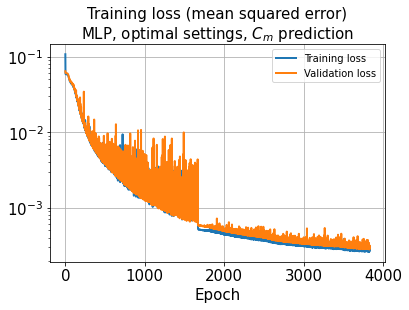

In [34]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nMLP, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

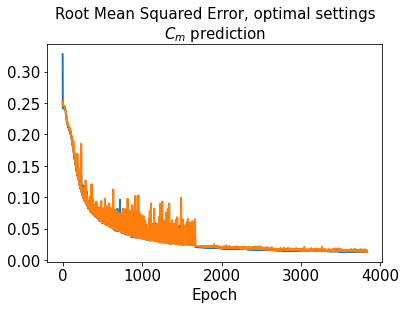

In [35]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

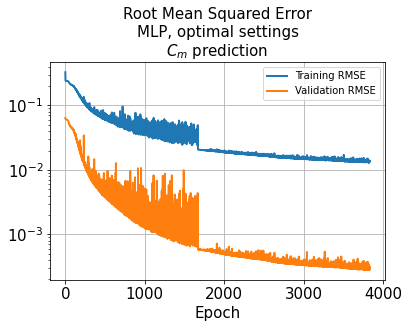

In [36]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nMLP, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [37]:
train_results = model.evaluate(x_train, y_train)

657/657 [==============================] - 2s 3ms/step - loss: 2.6156e-04 - rmse: 0.0131


In [38]:
val_results = model.evaluate(x_val, y_val)

188/188 [==============================] - 1s 3ms/step - loss: 2.8912e-04 - rmse: 0.0141


In [39]:
test_results = model.evaluate(x_test, y_test)

94/94 [==============================] - 0s 3ms/step - loss: 2.5191e-04 - rmse: 0.0127


In [40]:
decoded_train_ = model.predict(x_train)
decoded_val_ = model.predict(x_val)
decoded_test_ = model.predict(x_test)

94/94 [==============================] - 0s 1ms/step


In [41]:
def define_index(cm, y):
    return np.unique(np.where(np.isin(cm, y)))

In [42]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [43]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

In [44]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real)*np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real+y_pred)

In [45]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [46]:
l2_error_train = l2_error(decoded_train_, y_train)
mape_train = smape(decoded_train_, y_train)
print(l2_error_train)
print(mape_train)

0.030064408272045845
1.107743253198925


In [47]:
l2_error_val = l2_error(decoded_val_, y_val)
mape_val= smape(decoded_val_, y_val)
print(l2_error_val)
print(mape_val)

0.03224310284648857
1.193395565574035


In [48]:
l2_error_test = l2_error(decoded_test_, y_test)
mape_test= smape(decoded_test_, y_test)
print(l2_error_test)
print(mape_test)

0.02914716940985451
1.1040204317615814


In [49]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [50]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [51]:
model_directory = "D:\\TrainedModels\\20221229"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221229unsteadyValidation_MLP_6beta_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_layers) +"layers_"+str(n_units)+"units_CmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [53]:
os.chdir(storage_dir)

In [54]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [55]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [56]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [57]:
mape_train_list = []
for i in range(0, len(x_train)):
    mape_train_data = smape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [58]:
mape_val_list = []
for i in range(0, len(x_val)):
    mape_val_data = smape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [59]:
mape_test_list = []
for i in range(0, len(x_test)):
    mape_test_data = smape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [60]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

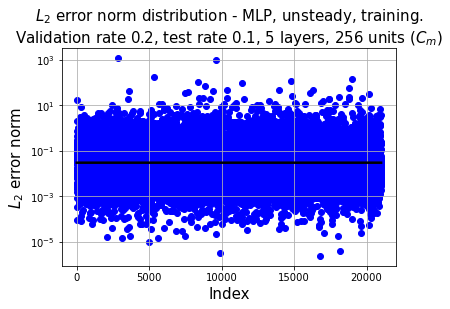

In [61]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

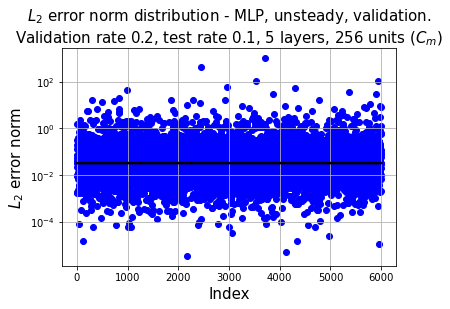

In [62]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

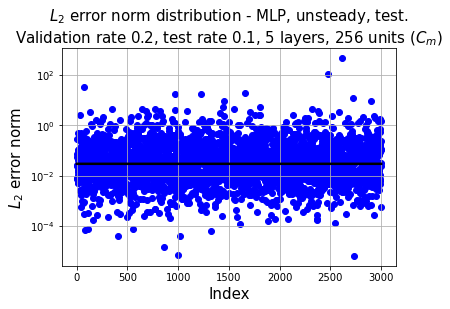

In [63]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [64]:
predicted = model.predict(x)

938/938 [==============================] - 1s 1ms/step


In [65]:
tTrain = t[index_train]+10
tVal = t[index_val]+10
tTest = t[index_test]+10

In [66]:
index_train.shape

(21001,)

In [67]:
max(predicted)

array([1.0155079], dtype=float32)

In [68]:
l2_error(denormalize(predicted), denormalize(y))

0.04174310970836813

In [69]:
l2_error(predicted, y)

0.03042665717462583

In [70]:
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [71]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [72]:
x[:,0] *= 5
x[:,0] += 10

In [73]:
def Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    title_Cm = title_n_Cm
    savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
    plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    plt.ylim([-0.05, 0.22])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

L2 error of Cm: 0.0183


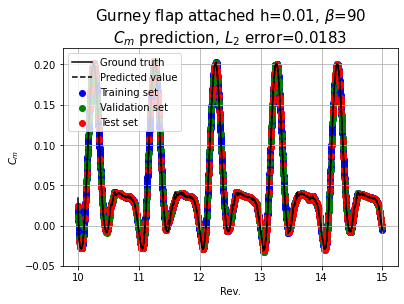

L2 error of Cm: 0.0172


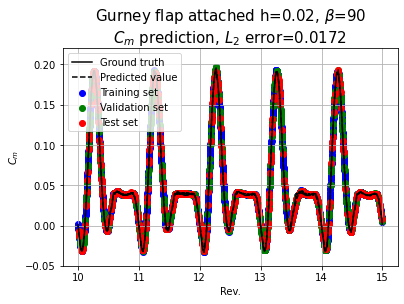

L2 error of Cm: 0.0293


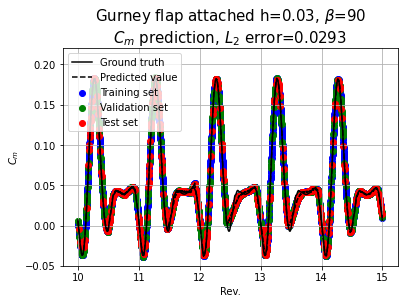

L2 error of Cm: 0.0297


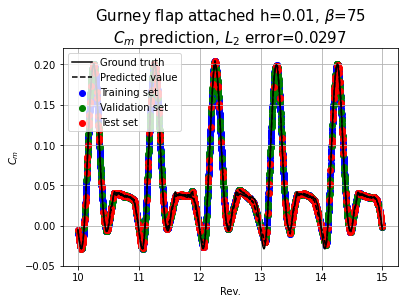

L2 error of Cm: 0.0336


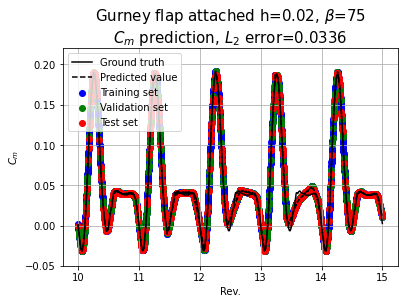

L2 error of Cm: 0.0463


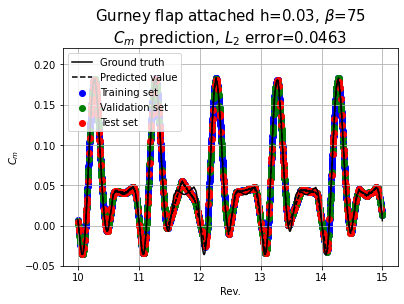

In [79]:
h = [0.01, 0.02, 0.03, 0.01, 0.02, 0.03]
beta = [90, 90, 90, 75, 75, 75]
for i in range(0,6):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

In [80]:
def Cm_trainTestSplit_Plot2(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
#     title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm), 'b--', label='Predicted value')
#     plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
#     plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#     plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

L2 error of Cm: 0.0183


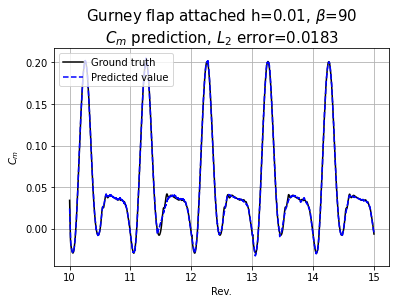

L2 error of Cm: 0.0172


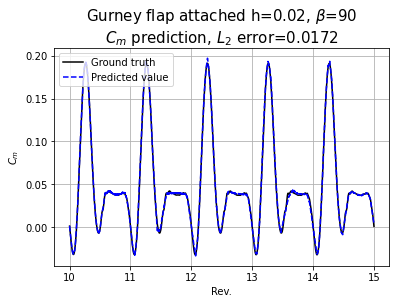

L2 error of Cm: 0.0293


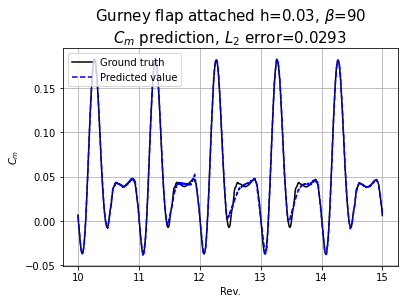

L2 error of Cm: 0.0297


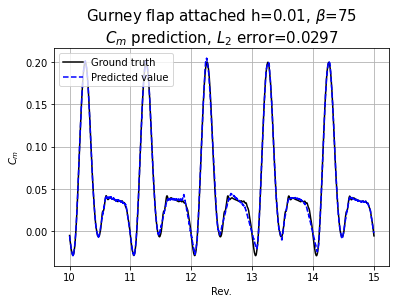

L2 error of Cm: 0.0336


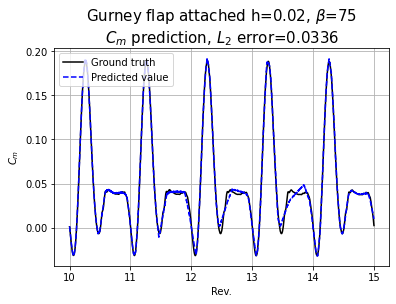

L2 error of Cm: 0.0463


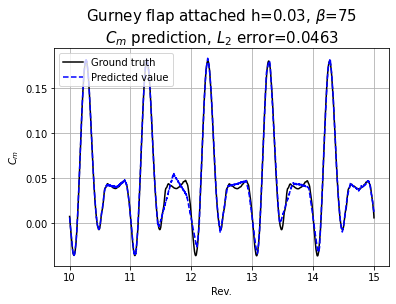

In [81]:
for i in range(0,6):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot2(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

L2 error of Cm: 0.0183


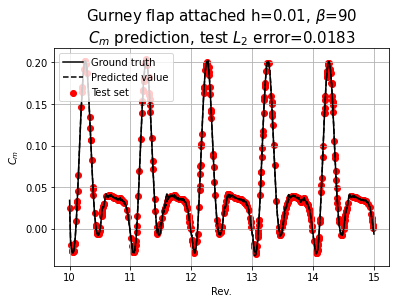

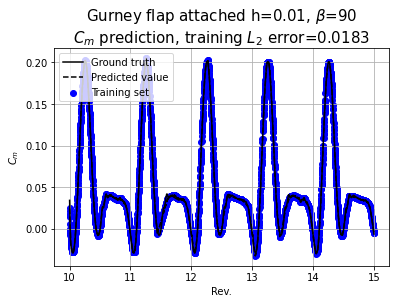

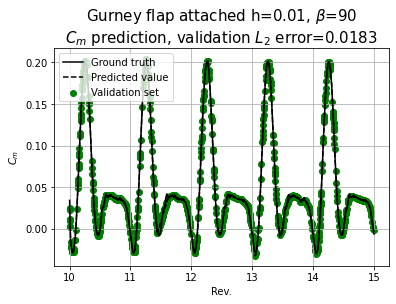

L2 error of Cm: 0.0172


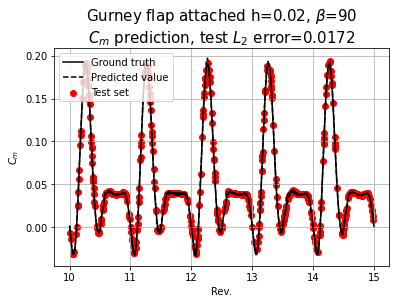

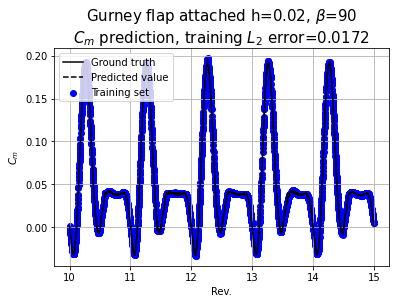

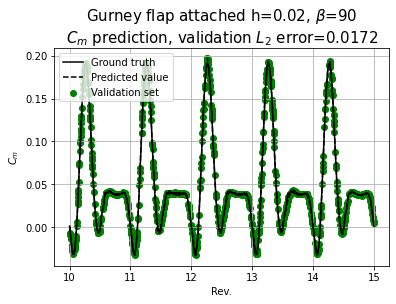

L2 error of Cm: 0.0293


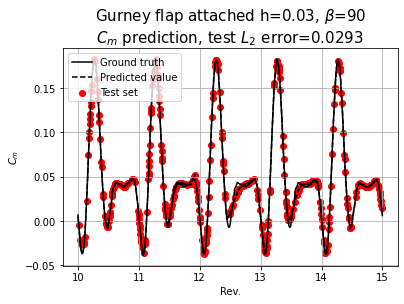

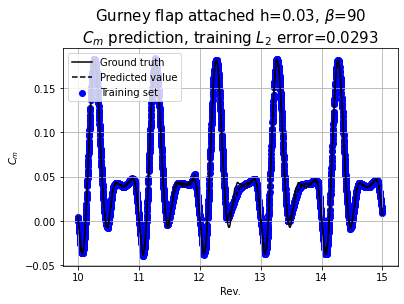

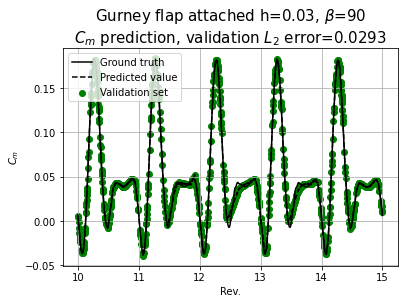

L2 error of Cm: 0.0297


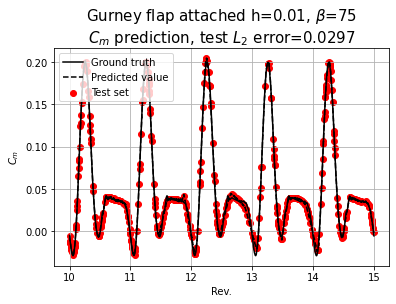

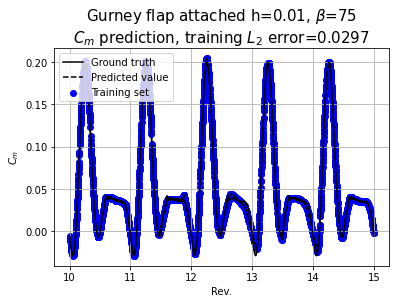

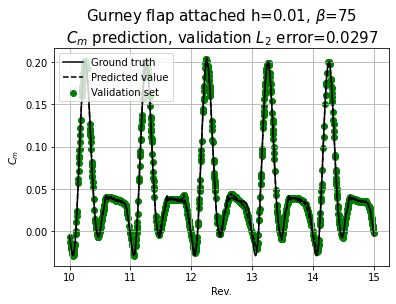

L2 error of Cm: 0.0336


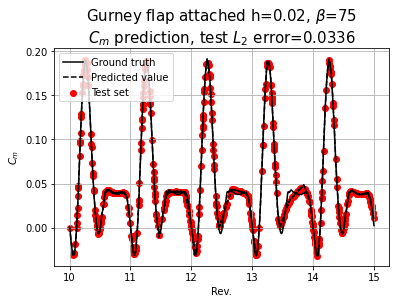

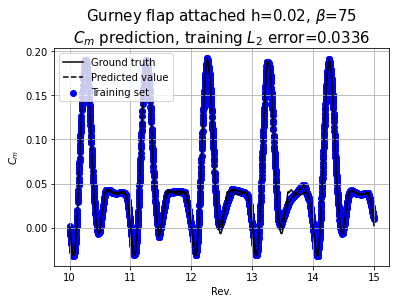

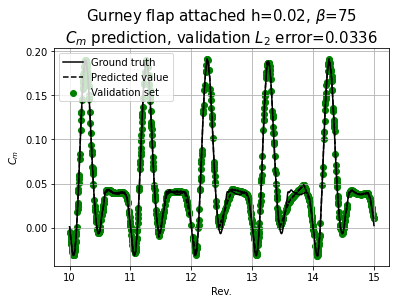

L2 error of Cm: 0.0463


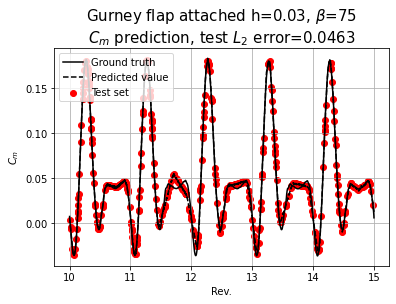

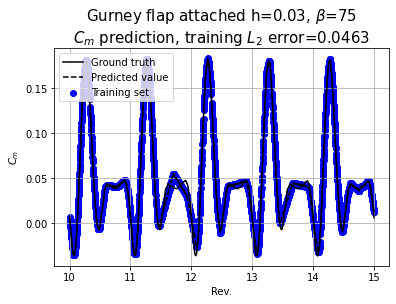

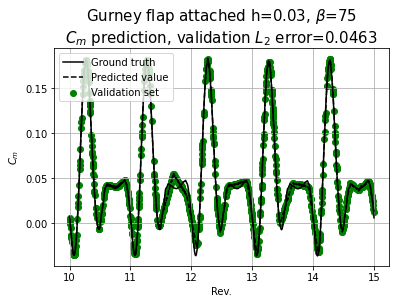

In [82]:
for i in range(0,6):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    title_Cm = title_n_Cm
    savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"

    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    title_train = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, training $L_2$ error=%.4f'%(l2_error_Cm)
    title_val = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, validation $L_2$ error=%.4f'%(l2_error_Cm)
    title_test = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, test $L_2$ error=%.4f'%(l2_error_Cm)
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
    
    savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+"training.jpg"
    savename2 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+"validation.jpg"
    savename3 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+"test.jpg"
#     Cm_trainTestSplit_Plot2(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

    # CD graph plot
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm_), 'k--', label='Predicted value')
    #plt.scatter(tTrain, iTrain, color='b', label='Training set')
    #plt.scatter(tVal, iVal, color='g', label='Validation set')
    plt.scatter(tTest, denormalize(iTest_), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_test, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename3, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm_), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain_), color='b', label='Training set')
    #plt.scatter(tVal, iVal, color='g', label='Validation set')
#     plt.scatter(tTest, denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_train, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm_), 'k--', label='Predicted value')
    #plt.scatter(tTrain, iTrain, color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal_), color='g', label='Validation set')
#     plt.scatter(tTest, denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_val, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename2, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()